In [1]:
%matplotlib inline

import datetime as dt
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import pydotplus 


from collections import defaultdict
from datetime import datetime
from IPython.display import Image  
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats.stats import mode, pearsonr
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import export_graphviz
from sklearn import metrics
from sklearn.metrics import classification_report

In [2]:
# Loading dataset.

custom_date_parser = lambda x: datetime.strptime(x, "%d/%m/%y %H:%M")

df = pd.read_csv('customer_supermarket.csv', sep='\t', decimal=',',
                 parse_dates=['BasketDate'], date_parser=custom_date_parser, index_col=0)

df['CustomerID'] = df['CustomerID'].astype(float)

# Data Understanding

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 471910 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   BasketID         471910 non-null  object        
 1   BasketDate       471910 non-null  datetime64[ns]
 2   Sale             471910 non-null  float64       
 3   CustomerID       406830 non-null  float64       
 4   CustomerCountry  471910 non-null  object        
 5   ProdID           471910 non-null  object        
 6   ProdDescr        471157 non-null  object        
 7   Qta              471910 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.4+ MB


In [4]:
df.isnull().sum()

BasketID               0
BasketDate             0
Sale                   0
CustomerID         65080
CustomerCountry        0
ProdID                 0
ProdDescr            753
Qta                    0
dtype: int64

13% of CustomerID are null, 0.15% of ProdDescr are null.

In [5]:
df.describe()

,Sale,CustomerID,Qta
count,471910.000000,406830.000000,471910.000000
mean,4.030945,15287.684160,10.716533
std,83.769380,1713.603074,231.355136
min,-11062.060000,12346.000000,-80995.000000
25%,1.250000,13953.000000,1.000000
50%,2.080000,15152.000000,4.000000
75%,3.750000,16791.000000,12.000000
max,38970.000000,18287.000000,80995.000000


Detected anomalies:
- negative sales;
- negative quantities;
- huge maximum sale;
- huge maximum quantity.

In [6]:
df[df['Sale'] < 0].head()

,BasketID,BasketDate,Sale,CustomerID,CustomerCountry,ProdID,ProdDescr,Qta
299983,A563186,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom,B,Adjust bad debt,1
299984,A563187,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom,B,Adjust bad debt,1


The records with negative sale have a leading 'A', that we suppose means "aborted transaction".

In [7]:
df[df['Qta'] < 0].head()

,BasketID,BasketDate,Sale,CustomerID,CustomerCountry,ProdID,ProdDescr,Qta
141,C536379,2010-12-01 09:41:00,27.50,14527.0,United Kingdom,D,Discount,-1
154,C536383,2010-12-01 09:49:00,4.65,15311.0,United Kingdom,35004C,SET OF 3 COLOURED FLYING DUCKS,-1
235,C536391,2010-12-01 10:24:00,1.65,17548.0,United Kingdom,22556,PLASTERS IN TIN CIRCUS PARADE,-12
236,C536391,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,21984,PACK OF 12 PINK PAISLEY TISSUES,-24
237,C536391,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24


All the records with negative quantities have BaskedIDs with a leading 'C', that we assume means "canceled order".
The order's entries have been modified in-place, so...

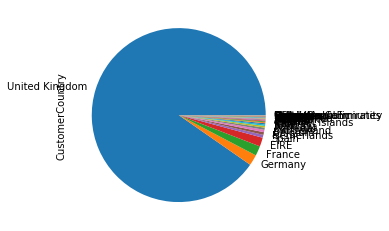

In [8]:
# Customers' nationalities.

countries = df['CustomerCountry'].value_counts()
ax = countries.plot.pie()

All the countries are real, but there are 340 unspecified records' countries.

## Data distribution and quality

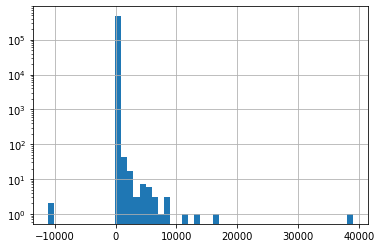

In [9]:
# Sales distribution.

ax = df.Sale.hist(log=True, bins=50)

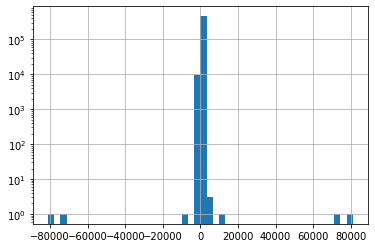

In [10]:
# Qta distribution.

ax = df.Qta.hist(log=True, bins=50)

The majority of purchases have low price.

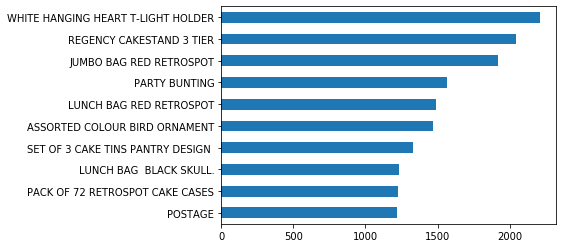

In [11]:
# Top-10 products.

ax = df['ProdDescr'].value_counts().head(10).plot(kind='barh')
ax.invert_yaxis()

The first 9 most sold products are legit ones, but the 10th is "postage", that we assume is related to the shipping, and we're not considering it as a valid product.

After a deeper analysis we've detected some unusual and erroneous ProdID and ProdDescr, and we've put them in two files: blacklist_prod_descr.csv and blacklist_prod_id.csv. An example is a descrition that mocks a colleague, also with typos: "alan hodge cant mamage this section".

Analyzing the data, we also found this relation: (ProdDescr = null) $\Rightarrow$ (CustomerID = null $\land$ Sale = 0).

### CustomerID analysis

Given the high number of null CustomerIDs, we decided to consider them valid, under certain conditions (see next).

# Data preparation

## New features

We want to analyze the customers' behavior on the day of the week.

In [12]:
df['BasketDay'] = df['BasketDate'].dt.day_name()

As said before, the BasketID starting with a 'C' have been considered canceled. We added a new booleand field "Canceled" to keep track of them, then we removed the 'C' from the BasketID, and we reversed the quantity for further simplicity.

In [13]:
canceled = "C"
df['Canceled'] = df['BasketID'].apply(lambda x : x.startswith(canceled))
df['BasketID'] = df['BasketID'].apply(lambda x : x[1:] if x.startswith(canceled) else x)
df['Qta'] = np.where(df['Canceled'], abs(df['Qta']), df['Qta'])

We compute the total price of every row.

In [14]:
df['Total'] = df['Sale'] * df['Qta']

## Data cleaning

Remove the aborted transactions.

In [15]:
df = df[~(df['Sale'] < 0)]
df['BasketID'] = df['BasketID'].astype(int)

Then we remove the rows with bad ProdDescr and ProdID.

In [16]:
# To find bad descriptions.
#df['ProdDescr'].value_counts().to_csv('prodlist.csv')

In [17]:
with open('blacklist_prod_descr.csv') as f:
    blacklist = [line.strip() for line in f]

df = df[~df['ProdDescr'].isin(blacklist)]

In [18]:
# If len < 5 or > 6, probably not a valid product. We made another blacklist.

with open('blacklist_prod_id.csv') as f:
    blacklist = [line.strip() for line in f]

df = df[~df['ProdID'].isin(blacklist)]

We found few zero prices, and in most of the cases, also null ProdDescr. We decided to get rid of them.

In [19]:
df = df[~(df['Sale'] == 0)]

There are still too small values of Sale (less than 1 penny). We remove them.

In [20]:
df = df[~(df['Sale'] < 0.01)]

5.27% of BasketIDs removed.

In [21]:
# Percentage for each country dropped.

countries_after = df['CustomerCountry'].value_counts()
dropped = (1 - countries_after.divide(countries)) * 100
dropped

Australia               0.397141
Austria                 3.491272
Bahrain                 0.000000
Belgium                 4.736588
Brazil                  0.000000
Canada                  0.662252
Channel Islands         0.659631
Cyprus                  0.482315
Czech Republic          6.666667
Denmark                 3.598972
EIRE                    1.495399
European Community      4.918033
Finland                 6.043165
France                  3.800587
Germany                 4.212744
Greece                  2.739726
Hong Kong               2.173913
Iceland                 0.000000
Israel                  0.000000
Italy                   2.490660
Japan                   0.837989
Lebanon                 0.000000
Lithuania               0.000000
Malta                   3.149606
Netherlands             1.897933
Norway                  2.486188
Poland                  1.466276
Portugal                2.943144
RSA                     1.724138
Saudi Arabia            0.000000
Singapore 

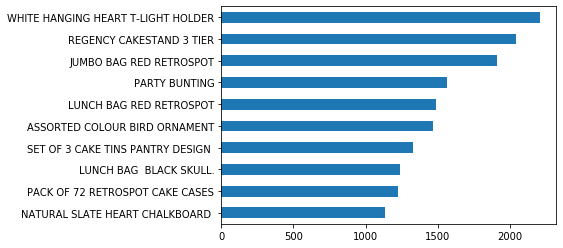

In [22]:
# New top-10 products.

ax = df['ProdDescr'].value_counts().head(10).plot(kind='barh')
ax.invert_yaxis()

In [23]:
df.describe()

,BasketID,Sale,CustomerID,Qta,Total
count,468251.000000,468251.000000,404876.000000,468251.000000,468251.000000
mean,560237.417710,3.108507,15295.253282,12.028444,21.287866
std,13289.254039,4.461019,1710.404209,231.039821,393.345586
min,536365.000000,0.030000,12346.000000,1.000000,0.060000
25%,548497.000000,1.250000,13969.000000,2.000000,4.130000
50%,561087.000000,2.080000,15159.000000,4.000000,10.200000
75%,571931.000000,3.750000,16794.000000,12.000000,17.700000
max,581587.000000,649.500000,18287.000000,80995.000000,168469.600000


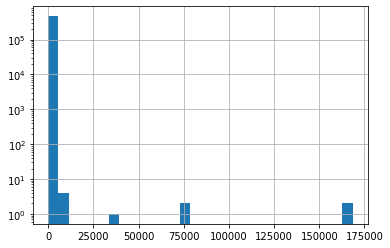

In [24]:
ax = df.Total.hist(log=True, bins=30)
#ax.set_xlim((0, 82000))

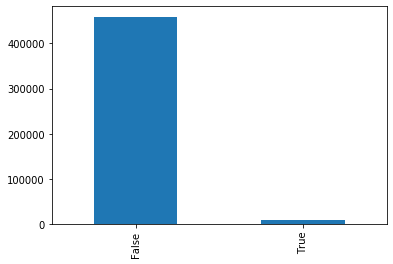

In [25]:
ax = df['Canceled'].value_counts().plot(kind='bar')

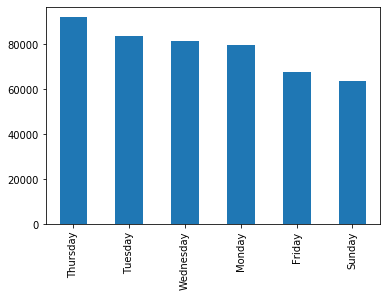

In [26]:
ax = df['BasketDay'].value_counts().plot(kind='bar')

There are no sales on saturday.

In [27]:
not_canceled = df[~(df['Canceled'])]

# Shopping sessions.
#ss_total = not_canceled.groupby(['BasketID']).agg({'Qta': 'mean'})

#ax = ss_total.Qta.hist(bins=100000)
#ax.set_xlim((0, 100))

In [28]:
#ax = ss_total.plot.scatter(x='Qta', y='Total')

In [29]:
# total number of items purchased by a customer during a period.
'''
start_date = '2010-12-01'
end_date = '2011-12-05'

mask = (not_canceled['BasketDate'] >= start_date) & (not_canceled['BasketDate'] <= end_date)
filtered = not_canceled.loc[mask]
ss_l = filtered.groupby('CustomerID').agg({'Qta': 'sum'})
ax = ss_l.Qta.hist(log=True, bins=60)'''

"\nstart_date = '2010-12-01'\nend_date = '2011-12-05'\n\nmask = (not_canceled['BasketDate'] >= start_date) & (not_canceled['BasketDate'] <= end_date)\nfiltered = not_canceled.loc[mask]\nss_l = filtered.groupby('CustomerID').agg({'Qta': 'sum'})\nax = ss_l.Qta.hist(log=True, bins=60)"

In [30]:
# total number of distinct items purchased by a customer during a period.
'''
start_date = '2010-12-01'
end_date = '2011-12-05'

mask = (not_canceled['BasketDate'] >= start_date) & (not_canceled['BasketDate'] <= end_date)
filtered = not_canceled.loc[mask]
ss_lu = filtered.groupby(['CustomerID', 'ProdID']).agg({'Qta': 'count'})
ax = ss_lu.Qta.hist(log=True, bins=70)'''

"\nstart_date = '2010-12-01'\nend_date = '2011-12-05'\n\nmask = (not_canceled['BasketDate'] >= start_date) & (not_canceled['BasketDate'] <= end_date)\nfiltered = not_canceled.loc[mask]\nss_lu = filtered.groupby(['CustomerID', 'ProdID']).agg({'Qta': 'count'})\nax = ss_lu.Qta.hist(log=True, bins=70)"

In [31]:
# max number of items purchased by a customer during a shopping session.
'''
start_date = '2010-12-01'
end_date = '2011-12-05'

mask = (not_canceled['BasketDate'] >= start_date) & (not_canceled['BasketDate'] <= end_date)
filtered = not_canceled.loc[mask]
ss_temp = filtered.groupby(['BasketID']).agg({'Qta': 'sum'})
ss_imax = filtered.groupby(['CustomerID']).agg({'Qta': 'max'})
ax = ss_imax.Qta.hist(log=True, bins=70)'''

"\nstart_date = '2010-12-01'\nend_date = '2011-12-05'\n\nmask = (not_canceled['BasketDate'] >= start_date) & (not_canceled['BasketDate'] <= end_date)\nfiltered = not_canceled.loc[mask]\nss_temp = filtered.groupby(['BasketID']).agg({'Qta': 'sum'})\nss_imax = filtered.groupby(['CustomerID']).agg({'Qta': 'max'})\nax = ss_imax.Qta.hist(log=True, bins=70)"

In [32]:
# entropy on shopping date for customer predictability.
"""
customer_list = not_canceled['CustomerID'].unique()
entropies = []

for customer in customer_list:
    data = not_canceled[not_canceled['CustomerID'] == customer]
    prob = data['BasketDay'].value_counts()
    entropy = stats.entropy(prob)
    entropies.append(entropy)
"""

"\ncustomer_list = not_canceled['CustomerID'].unique()\nentropies = []\n\nfor customer in customer_list:\n    data = not_canceled[not_canceled['CustomerID'] == customer]\n    prob = data['BasketDay'].value_counts()\n    entropy = stats.entropy(prob)\n    entropies.append(entropy)\n"

In [33]:
#plt.hist(entropies, bins=50)
#plt.show()

In [34]:
# How many days since the last purchase?
recency = df.groupby(by='CustomerID', as_index=False)['BasketDate'].max()

last = df['BasketDate'].max() + dt.timedelta(days=1)

recency['Recency'] = recency['BasketDate'].apply(lambda x: (last - x).days)
del recency['BasketDate']
recency.head()

,CustomerID,Recency
0,12346.0,326
1,12347.0,2
2,12348.0,75
3,12349.0,19
4,12350.0,310


In [35]:
# How many times a customer has bought in this market?


frequency = not_canceled.groupby(by=['CustomerID'], as_index=False)['BasketID'].nunique()
frequency.columns = ['CustomerID', 'Frequency']
frequency.head()

,CustomerID,Frequency
0,12346.0,1
1,12347.0,7
2,12348.0,4
3,12349.0,1
4,12350.0,1


In [36]:
# How much has a customer spent?

monetary = not_canceled.groupby(by=['CustomerID'], as_index=False)['Total'].sum()
monetary.columns = ['CustomerID', 'Monetary']
monetary.head()

,CustomerID,Monetary
0,12346.0,77183.60
1,12347.0,4310.00
2,12348.0,1437.24
3,12349.0,1457.55
4,12350.0,294.40


In [37]:
median = not_canceled.groupby(by=['CustomerID', 'BasketID'], as_index=False)['Total'].sum()
median = median.groupby(by=['CustomerID'], as_index=False)['Total'].median()
median.columns = ['CustomerID', 'Median']
median

,CustomerID,Median
0,12346.0,77183.600
1,12347.0,584.910
2,12348.0,298.500
3,12349.0,1457.550
4,12350.0,294.400
...,...,...
4329,18280.0,180.600
4330,18281.0,80.820
4331,18282.0,89.025
4332,18283.0,113.500


In [38]:
# RFM table.

rfm = recency.merge(frequency.merge(monetary, on='CustomerID'), on='CustomerID')
rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,1,77183.60
1,12347.0,2,7,4310.00
2,12348.0,75,4,1437.24
3,12349.0,19,1,1457.55
4,12350.0,310,1,294.40


In [39]:
# Compute customer ranks on total money spent.

#rank = rfm.copy()
#rank['Rank'] = rank['Monetary'].rank(ascending=0)
#rank.sort_values('Rank', ascending=True).head()

In [40]:
quantiles = rfm.quantile(q=[0.2, 0.4, 0.6, 0.8])
quantiles

,CustomerID,Recency,Frequency,Monetary
0.2,13505.6,11.0,1.0,248.534
0.4,14705.6,31.0,2.0,484.846
0.6,15882.8,70.0,3.0,925.250
0.8,17080.4,176.0,5.0,2043.426


In [41]:
def RScore(x, data, thresh):
    if x <= thresh[data][0.2]:
        return 5
    elif x <= thresh[data][0.4]:
        return 4
    elif x <= thresh[data][0.6]:
        return 3
    elif x <= thresh[data][0.8]:
        return 2
    else:
        return 1

def FMScore(x, data, thresh):
    if x <= thresh[data][0.2]:
        return 1
    elif x <= thresh[data][0.4]:
        return 2
    elif x <= thresh[data][0.6]:
        return 3
    elif x <= thresh[data][0.8]:
        return 4
    else:
        return 5

In [42]:
rfm_scored = rfm.copy()
rfm_scored['RScore'] = rfm_scored['Recency'].apply(RScore, args=('Recency', quantiles))
rfm_scored['FScore'] = rfm_scored['Frequency'].apply(FMScore, args=('Frequency', quantiles))
rfm_scored['MScore'] = rfm_scored['Monetary'].apply(FMScore, args=('Monetary', quantiles))
rfm_scored['RFMScore'] = rfm_scored['RScore'] + rfm_scored['FScore'] + rfm_scored['MScore']
rfm_scored

,CustomerID,Recency,Frequency,Monetary,RScore,FScore,MScore,RFMScore
0,12346.0,326,1,77183.60,1,1,5,7
1,12347.0,2,7,4310.00,5,5,5,15
2,12348.0,75,4,1437.24,2,4,4,10
3,12349.0,19,1,1457.55,4,1,4,9
4,12350.0,310,1,294.40,1,1,2,4
...,...,...,...,...,...,...,...,...
4329,18280.0,278,1,180.60,1,1,1,3
4330,18281.0,181,1,80.82,1,1,1,3
4331,18282.0,8,2,178.05,5,2,1,8
4332,18283.0,4,16,2088.93,5,5,5,15


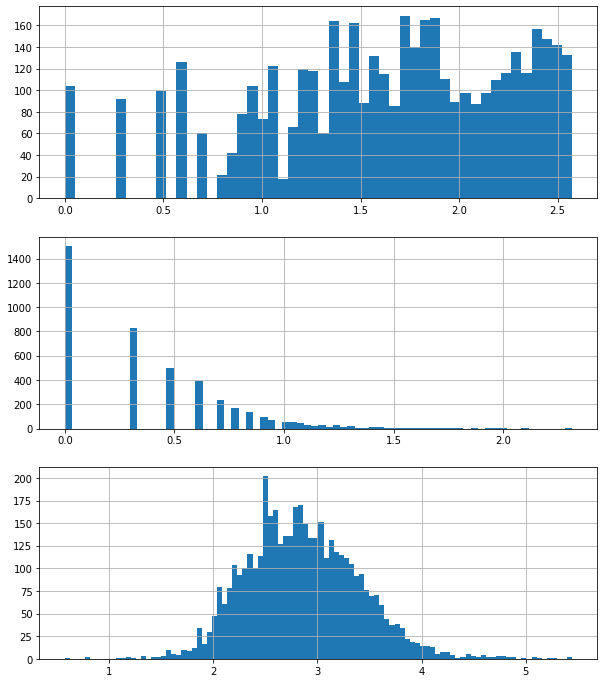

In [43]:
rfm_log = rfm[['Recency', 'Frequency', 'Monetary']].apply(np.log10, axis=1).round(3)

# plot the distribution of RFM values
f, ax = plt.subplots(figsize=(10, 12))
plt.subplot(3, 1, 1); rfm_log.Recency.hist(bins=50, label='Recency')
plt.subplot(3, 1, 2); rfm_log.Frequency.hist(bins=70, label='Frequency')
plt.subplot(3, 1, 3); rfm_log.Monetary.hist(bins=100, label='Monetary')
plt.show()

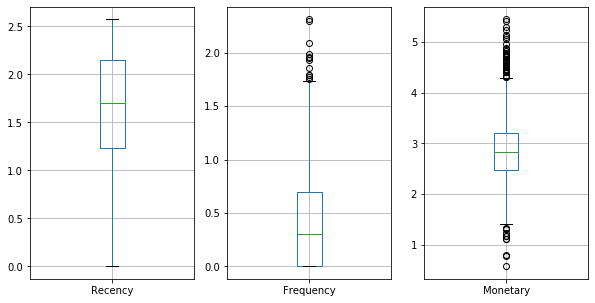

In [44]:
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
rfm_log.boxplot('Recency', ax=ax[0])
rfm_log.boxplot('Frequency', ax=ax[1])
rfm_log.boxplot('Monetary', ax=ax[2])

# Clustering

In [45]:
rfm_k = rfm_log[['Recency', 'Frequency', 'Monetary']]
scaler = StandardScaler()
scaled = scaler.fit_transform(rfm_k.values)

In [46]:
sse = []
for k in range(2, 7):
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=100)
    kmeans.fit(scaled)
    sse.append(kmeans.inertia_)

In [47]:
# Elbow curve.
#ax = plt.plot(range(2, 31), sse)
#plt.show()

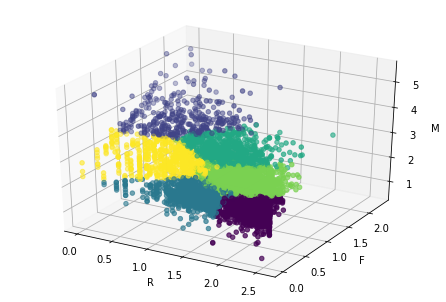

In [48]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(rfm_log['Recency'], rfm_log['Frequency'], rfm_log['Monetary'], c=kmeans.labels_)
ax.set_xlabel('R')
ax.set_ylabel('F')
ax.set_zlabel('M')
plt.show()

In [49]:
#rfm_den = rfm_log[['Frequency','Monetary','Recency']]
density = DBSCAN(eps=0.35, min_samples=7).fit(scaled)

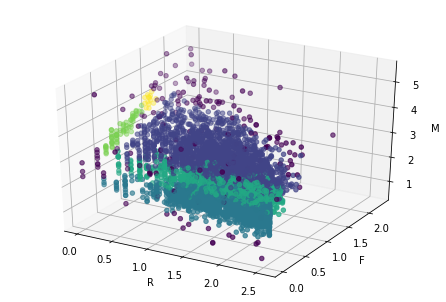

In [50]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(rfm_log['Recency'], rfm_log['Frequency'], rfm_log['Monetary'], c=density.labels_)
ax.set_xlabel('R')
ax.set_ylabel('F')
ax.set_zlabel('M')
plt.show()

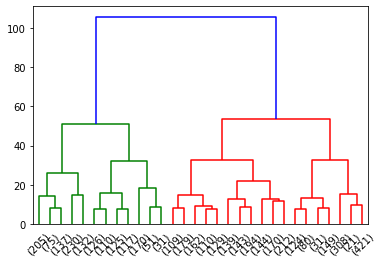

In [51]:
data_dist = pdist(scaled, metric='euclidean')
data_link = linkage(data_dist, method='ward', metric='euclidean')
res = dendrogram(data_link, truncate_mode='lastp')

# Classification

In [52]:
# Relative monetary
relative = df.groupby(by='CustomerID', as_index=False).BasketDate.agg(['min', 'max'])

last = df['BasketDate'].max() + dt.timedelta(days=1)

relative['Days'] = relative['min'].apply(lambda x: (last - x).days)

relative = recency.merge(relative.merge(monetary.merge(frequency, on='CustomerID'), on='CustomerID'), on='CustomerID')

relative['Delta'] = (relative['max'] - relative['min']).dt.days + 1
relative['R_Monetary'] = relative['Monetary'] / relative['Delta']
relative['R_Frequency'] = relative['Frequency'] / relative['Delta']

del relative['Monetary']
del relative['Days']
del relative['Delta']
del relative['max']
del relative['min']

In [53]:
customer_profile = relative.copy()
customer_profile.head()

,CustomerID,Recency,Frequency,R_Monetary,R_Frequency
0,12346.0,326,1,77183.600000,1.000000
1,12347.0,2,7,11.775956,0.019126
2,12348.0,75,4,5.078587,0.014134
3,12349.0,19,1,1457.550000,1.000000
4,12350.0,310,1,294.400000,1.000000


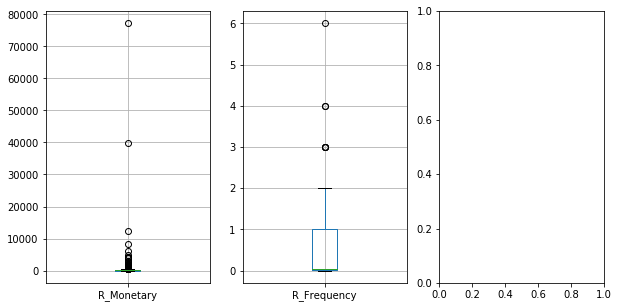

In [54]:
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
customer_profile.boxplot('R_Monetary', ax=ax[0])
customer_profile.boxplot('R_Frequency', ax=ax[1])

In [55]:
customer_profile.describe()

,CustomerID,Recency,Frequency,R_Monetary,R_Frequency
count,4334.000000,4334.000000,4334.000000,4334.000000,4334.000000
mean,15299.251731,90.825104,4.245962,154.726250,0.363940
std,1721.994109,99.479900,7.634989,1366.773747,0.495490
min,12346.000000,1.000000,1.000000,0.111125,0.002762
25%,13812.250000,17.000000,1.000000,5.634888,0.019433
50%,15297.500000,50.000000,2.000000,15.296317,0.042553
75%,16778.750000,140.000000,5.000000,145.842500,1.000000
max,18287.000000,374.000000,206.000000,77183.600000,6.000000


In [56]:
ranges_m = [0.4, 0.85]
quantiles_m = customer_profile.quantile(q=ranges_m)
quantiles_m

,CustomerID,Recency,Frequency,R_Monetary,R_Frequency
0.40,14705.6,31.0,2.0,10.092559,0.029412
0.85,17394.1,216.0,7.0,270.805000,1.000000


In [57]:
ranges_f = [0.3, 0.7]
quantiles_f = customer_profile.quantile(q=ranges_f)
quantiles_f

,CustomerID,Recency,Frequency,R_Monetary,R_Frequency
0.3,14109.9,21.0,1.0,6.802132,0.022059
0.7,16480.2,107.0,4.0,101.205000,1.000000


In [58]:
ranges_r = [0.3, 0.66]
quantiles_r = customer_profile.quantile(q=ranges_r)
quantiles_r

,CustomerID,Recency,Frequency,R_Monetary,R_Frequency
0.30,14109.90,21.0,1.0,6.802132,0.022059
0.66,16241.78,86.0,4.0,60.634080,0.200000


In [59]:
def ScoreM(x, data, thresh):
    if x <= thresh[data][ranges_m[0]]:
        return 1
    elif x <= thresh[data][ranges_m[1]]:
        return 2
    else:
        return 3

def ScoreF(x, data, thresh):
    if x <= thresh[data][ranges_f[0]]:
        return 1
    elif x <= thresh[data][ranges_f[1]]:
        return 2
    else:
        return 3

def ScoreR(x, data, thresh):
    if x <= thresh[data][ranges_r[0]]:
        return 3
    elif x <= thresh[data][ranges_r[1]]:
        return 2
    else:
        return 1

In [60]:
customer_profile['MScore'] = customer_profile['R_Monetary'].apply(ScoreM, args=('R_Monetary', quantiles_m))
customer_profile['FScore'] = customer_profile['R_Frequency'].apply(ScoreF, args=('R_Frequency', quantiles_f))
customer_profile['RScore'] = customer_profile['Recency'].apply(ScoreR, args=('Recency', quantiles_r))
customer_profile['Score'] = (0.5 * customer_profile['MScore']
                            + 0 * customer_profile['FScore']
                            + 0.25 * customer_profile['RScore'])
customer_profile.describe()

,CustomerID,Recency,Frequency,R_Monetary,R_Frequency,MScore,FScore,RScore,Score
count,4334.000000,4334.000000,4334.000000,4334.000000,4334.000000,4334.000000,4334.000000,4334.000000,4334.000000
mean,15299.251731,90.825104,4.245962,154.726250,0.363940,1.749885,1.712275,1.962160,1.365482
std,1721.994109,99.479900,7.634989,1366.773747,0.495490,0.698301,0.480453,0.798943,0.362880
min,12346.000000,1.000000,1.000000,0.111125,0.002762,1.000000,1.000000,1.000000,0.750000
25%,13812.250000,17.000000,1.000000,5.634888,0.019433,1.000000,1.000000,1.000000,1.000000
50%,15297.500000,50.000000,2.000000,15.296317,0.042553,2.000000,2.000000,2.000000,1.250000
75%,16778.750000,140.000000,5.000000,145.842500,1.000000,2.000000,2.000000,3.000000,1.750000
max,18287.000000,374.000000,206.000000,77183.600000,6.000000,3.000000,3.000000,3.000000,2.250000


In [61]:
ranges = [0.25, 0.8]
quantiles = customer_profile.quantile(q=ranges)
quantiles

,CustomerID,Recency,Frequency,R_Monetary,R_Frequency,MScore,FScore,RScore,Score
0.25,13812.25,17.0,1.0,5.634888,0.019433,1.0,1.0,1.0,1.00
0.80,17080.40,176.0,5.0,193.684000,1.000000,2.0,2.0,3.0,1.75


In [62]:
def Score(x, data, thresh):
    if x <= thresh[data][ranges[0]]:
        return 'Low'
    elif x <= thresh[data][ranges[1]]:
        return 'Medium'
    else:
        return 'High'

In [63]:
customer_labeled = customer_profile.copy()
customer_labeled['Label'] = customer_labeled['Score'].apply(Score, args=('Score', quantiles))
customer_labeled.head()

labels = customer_labeled.groupby('Label').CustomerID.unique()
# Sort the over-represented class to the head.
labels = labels[labels.apply(len).sort_values(ascending=False).index]
excess = len(labels.iloc[0]) - len(labels.iloc[1])
remove = np.random.choice(labels.iloc[0], excess, replace=False)
df2 = customer_labeled[~customer_labeled.CustomerID.isin(remove)]
customer_labeled = df2
df2

customer_labeled

,CustomerID,Recency,Frequency,R_Monetary,R_Frequency,MScore,FScore,RScore,Score,Label
2,12348.0,75,4,5.078587,0.014134,1,1,2,1.00,Low
3,12349.0,19,1,1457.550000,1.000000,3,2,3,2.25,High
5,12352.0,36,7,5.309349,0.026820,1,2,2,1.00,Low
7,12354.0,232,1,1079.400000,1.000000,3,2,1,1.75,Medium
9,12356.0,23,3,8.209340,0.009901,1,1,2,1.00,Low
...,...,...,...,...,...,...,...,...,...,...
4326,18276.0,21,1,14.602609,0.043478,2,2,3,1.75,Medium
4327,18277.0,58,1,0.422912,0.003831,1,1,2,1.00,Low
4329,18280.0,278,1,180.600000,1.000000,2,2,1,1.25,Medium
4331,18282.0,8,2,1.496218,0.016807,1,1,3,1.25,Medium


In [64]:
# Function to discretize the variables
# Input: the dataset and the list of variables' names to discretize
def discretize_data(dataset, variables):
    for variable in variables:
        mapping = {'High': 0, 'Medium': 1, 'Low': 2}

        # Add a new colum with the number representation of the variable
        dataset[variable+'_num'] = dataset[variable].map(mapping).astype(int)
    return dataset

In [65]:
variables = ['Label']

# Discretize data, in this case only Label
customer_labeled = discretize_data(customer_labeled, variables)

# Drop the categorical variables since we don't need them anymore 
customer_labeled.drop(columns=['CustomerID', 'Label', 'RScore', 'R_Monetary', 'FScore', 'MScore', 'Score', 'Frequency'], axis=1,inplace=True)

label = customer_labeled.pop('Label_num')

scaler = StandardScaler()
customer_labeled = scaler.fit_transform(customer_labeled.values)

train_set, test_set, train_label, test_label = train_test_split(customer_labeled, label, stratify=label, test_size=0.3)
#train_set.head()

In [66]:
train_label.head()

3225    1
3594    1
3638    2
2677    2
1580    2
Name: Label_num, dtype: int64

## Decision Tree

In [67]:
# Decision tree

dec_t = tree.DecisionTreeClassifier(criterion='gini', splitter='best',
                                  max_depth=4,
                                  min_samples_split=3, min_samples_leaf=10)

dec_t = dec_t.fit(train_set, train_label)

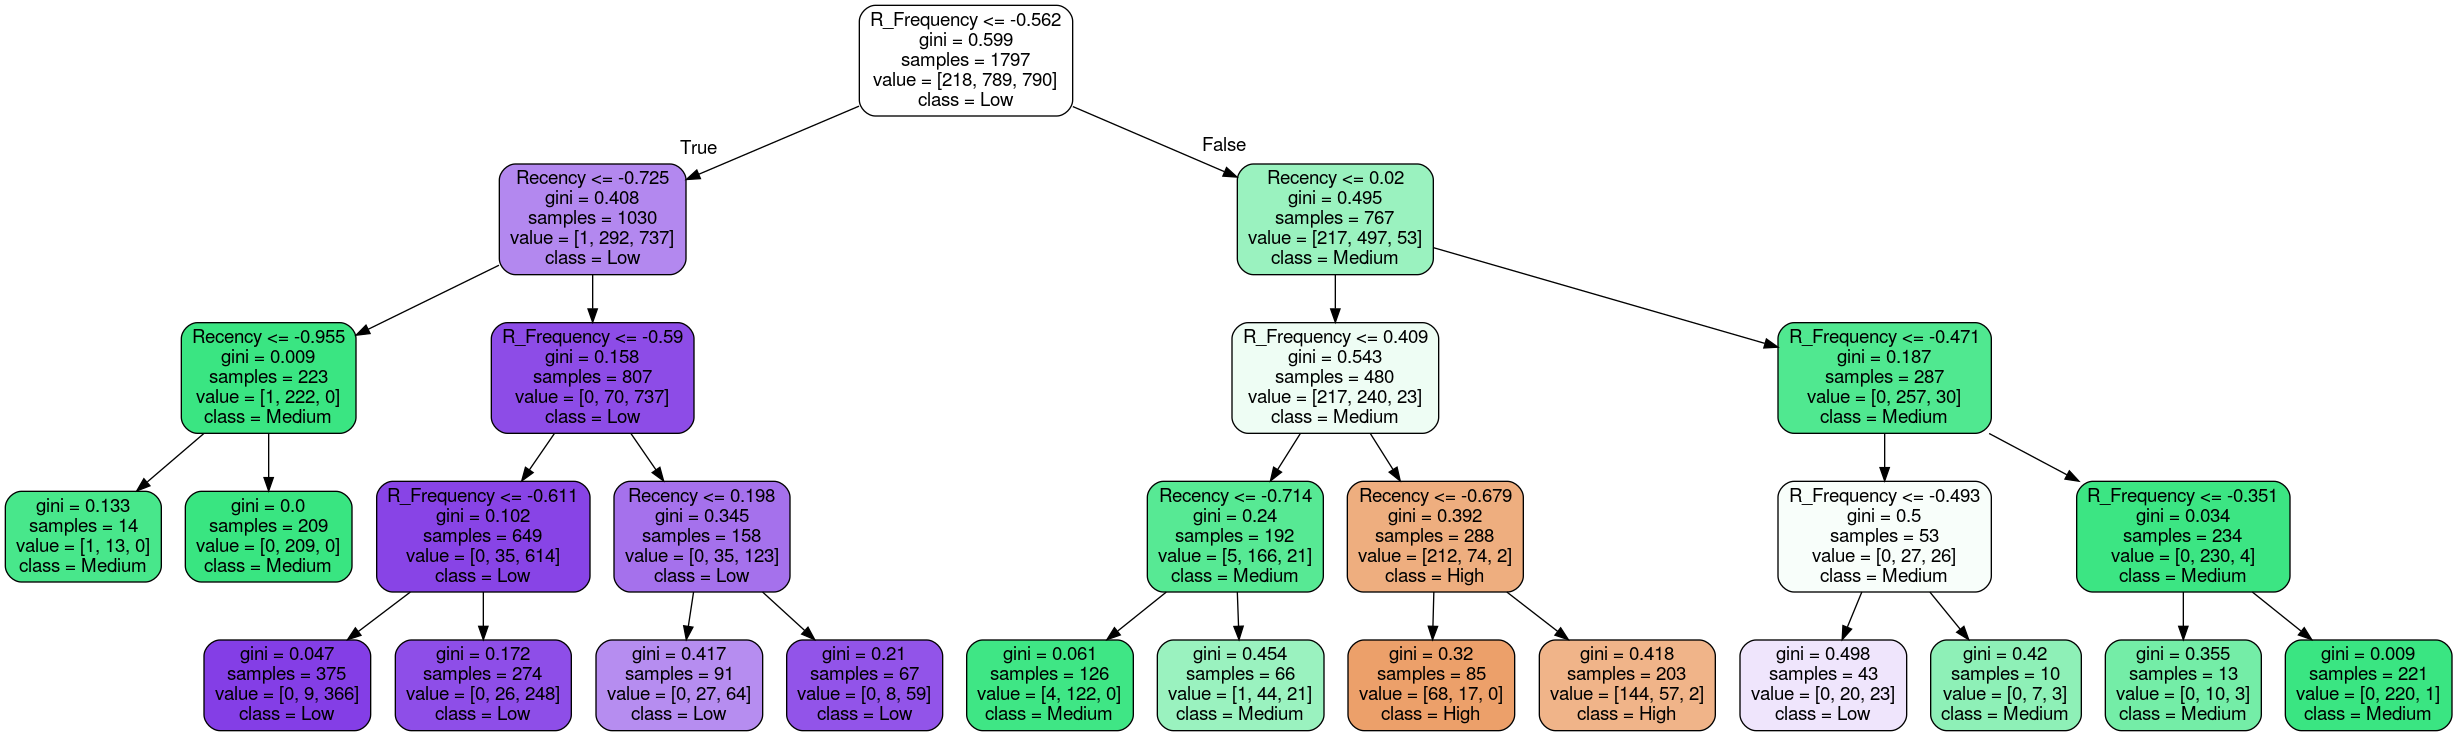

In [68]:
# Show decision tree

dot_data = tree.export_graphviz(dec_t, out_file=None,
                         feature_names=['Recency', 'R_Frequency'],
                         class_names=['High', 'Medium', 'Low'],
                         filled=True, rounded=True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [69]:
# Predict phase

train_pred_dt = dec_t.predict(train_set)
test_pred_dt = dec_t.predict(test_set)

### Evaluation of the decision tree: compute accuracy, precision, recall, confusion matrix

In [70]:
# Evaulate the accuracy on the train set and the test set

print('Accuracy train set ', metrics.accuracy_score(train_label, train_pred_dt))
print('Accuracy test set ', metrics.accuracy_score(test_label, test_pred_dt))
print('Precision train set ', metrics.precision_score(train_label, train_pred_dt, average='weighted'))
print('Recall train set ', metrics.recall_score(train_label, train_pred_dt, average='weighted'))
print('F1 score train set ', metrics.f1_score(train_label, train_pred_dt, average='weighted'))
print('Support train set ', metrics.precision_recall_fscore_support(train_label, train_pred_dt))

Accuracy train set  0.8887033945464663
Accuracy test set  0.8573281452658884
Precision train set  0.8987857714972084
Recall train set  0.8887033945464663
F1 score train set  0.8881351904079864
Support train set  (array([0.73611111, 0.94840668, 0.89411765]), array([0.97247706, 0.79214195, 0.96202532]), array([0.83794466, 0.86325967, 0.92682927]), array([218, 789, 790]))


In [73]:
# metrics computed on the test set
from sklearn.metrics import classification_report
print(classification_report(test_label, 
                            test_pred_dt, 
                            target_names=['High', 'Medium','Low']))

              precision    recall  f1-score   support

        High       0.66      0.97      0.79        94
      Medium       0.94      0.72      0.82       339
         Low       0.87      0.96      0.91       338

    accuracy                           0.86       771
   macro avg       0.83      0.88      0.84       771
weighted avg       0.88      0.86      0.86       771



In [77]:
# cross validation
# the score array for test/train scores on each cv split
# the time for fitting/scoring the estimator on the train set for each cv split
from sklearn.model_selection import cross_validate
import statistics 
scores = cross_validate(dec_t, train_set, train_label, cv=3, return_train_score= True)
print('Fit time ', statistics.mean(scores['fit_time']))
print('Score time ', statistics.mean(scores['score_time']))
print('Test score ', statistics.mean(scores['test_score']))
print('Train score ', statistics.mean(scores['train_score']))

Fit time  0.00489195187886556
Score time  0.0017667611440022786
Test score  0.8747913188647747
Train score  0.8895381190873678


In [78]:
# compute confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_label, test_pred_dt)
cm

array([[ 91,   3,   0],
       [ 46, 244,  49],
       [  0,  12, 326]])

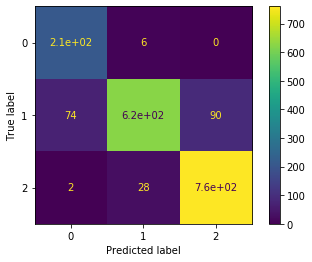

In [81]:
# it is possible to plot the confusion matrix 
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
plot_confusion_matrix(dec_t, train_set, train_label)
plt.show() 

## SVM

In [ ]:
#linear,poly,rbf,sigmoid,precomputed
from sklearn.svm import SVC

svm = SVC(kernel='sigmoid', C=0.5, gamma='scale')
svm.fit(train_set, train_label)

In [ ]:
#prediction on the test test
test_pred_proba_svm = svm.predict(test_set)

In [ ]:
test_pred_svm = svm.predict(test_set)

In [ ]:
#compute the performance of the model
print(classification_report(test_label, 
                            test_pred_svm, 
                            target_names=['High', 'Medium', 'Low']))

## KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=4, algorithm='ball_tree', metric='minkowski').fit(train_set, train_label)

In [ ]:
#prediction on the test test
test_pred_knn = knn.predict(test_set)

#compute the performance of the model

print(classification_report(test_label, 
                            test_pred_knn, 
                            target_names=['High', 'Medium', 'Low']))